In [26]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix
import time

In [27]:
# TODO: add these to a list that gets passed into the simulation and then to users when they are made
# will aloow for running multiple simulations with different parameters
post_rate_val_a = 0.2
post_rate_val_b = 1.5

comment_rate_val = 0.2

new_group_creation_chance_a = 1
new_group_creation_chance_b = 20

existing_group_join_chance_a = 3
existing_group_join_chance_b = 5

niche_score_val_a = 1
niche_score_val_b = 3

thread_popularity_length = 2 # days the thread will remain at max popularity
thread_decay_rate = 0.25 # proportion of popularity lost per day after max popularity

larger_group_join_rate = 1.75 # > 1 means more likely to join larger  groups

In [88]:
class User:
    def __init__(self, acct_id):
        self.id = acct_id
        # The rate at which a post is made
        self.post_rate = stats.beta(post_rate_val_a, post_rate_val_b).rvs()
        # The rate at which a comment is made
        self.comment_rate = round(stats.expon(comment_rate_val).rvs())
        # The chance of making a new group at the creation time of the user
        self.new_group_creation_chance = stats.beta(
            new_group_creation_chance_a, new_group_creation_chance_b
        ).rvs()
        # The chance of joining any existing group at the time of creation of the user
        self.existing_group_join_chance = stats.beta(
            existing_group_join_chance_a, existing_group_join_chance_b
        ).rvs()
        # A score that increases the probability of commenting in smaller, more niche groups
        self.niche_score = stats.beta(niche_score_val_a, niche_score_val_b).rvs()
        # self.niche_score = 0.0001
        self.groups = []
        self.posts = []
        self.comments = []


class Group:
    def __init__(self, group_id):
        self.id = group_id
        self.posts = []
        self.user_count = 0


class Post:
    def __init__(self, post_id, group_id, user):
        self.id = post_id
        self.group_id = group_id
        self.user = user
        self.age = 0
        self.comments = []
        # How active the post is - this can be useful for visualizations
        self.current_activity = 1
        self.highest_activity = 1


class Comment:
    def __init__(self, comment_id, post_id, parent_user_id, child_user_id):
        self.id = comment_id
        self.post_id = post_id
        self.parent_user_id = parent_user_id
        self.child_user_id = child_user_id


class Simulation:
    def __init__(self, num_users, num_groups, user_growth_rate, rounds):
        self.users = []
        self.groups = []
        self.posts = []
        self.comments = []
        self.user_growth_rate = user_growth_rate
        self.num_users = num_users
        self.num_groups = num_groups
        self.current_time = 0
        self.rounds = rounds
        self.interaction_matrix = dok_matrix(
            (
                num_users + user_growth_rate * rounds,
                num_users + user_growth_rate * rounds,
            ),
            dtype=np.int32,
        )
        self.initialize()

    def initialize(self):
        # create initial groups
        for i in range(self.num_groups):
            self.groups.append(Group(i))

        # create the users
        for i in range(self.num_users):
            self.add_user(larger_group_join_rate)

    def run(self):
        start_time = time.time()
        times = []
        for i in range(self.rounds):
            if i % 10 == 0 and i != 0:
                print(i, end=": ")
                if len(times) > 1:
                    avg_time = np.mean(times)
                    print("ETA:", round(avg_time * (self.rounds - i), 2), end="\r")
            round_start_time = time.time()
            self.current_time += 1

            ## Make posts
            self.make_users_post()

            user_post_time = round(time.time() - round_start_time, 2)
            # print("post: ", user_post_time, end=" ")

            ## Make comments
            self.make_users_comment()

            user_comment_time = round(
                time.time() - user_post_time - round_start_time, 2
            )
            # print("comment: ", user_comment_time, end=" ")

            ## Update post age and activity
            self.update_posts()

            post_update_time = round(
                (time.time() - user_comment_time - user_post_time - round_start_time), 2
            )
            # print("update: ", post_update_time, end=" ")

            ## Make users join groups
            self.make_users_join()

            user_group_join_time = (
                time.time()
                - post_update_time
                - user_comment_time
                - user_post_time
                - round_start_time
            )
            # print("join: ", user_group_join_time, end=" ")

            # add new users
            for i in range(self.user_growth_rate):
                self.add_user(larger_group_join_rate)

            # add new groups based on the user's new group creation chance
            for user in self.users[-self.user_growth_rate :]:
                if np.random.rand() < user.new_group_creation_chance:
                    self.groups.append(Group(len(self.groups)))
                    user.groups.append(self.groups[-1])
                    self.groups[-1].user_count += 1

            user_add_time = (
                time.time()
                - user_group_join_time
                - post_update_time
                - user_comment_time
                - user_post_time
                - round_start_time
            )
            # print("add: ", user_add_time, end=" ")

            total_round_time = time.time() - round_start_time
            times.append(total_round_time * 1.25)
            # print("total: ", total_round_time, "\n")

        total_time = round(time.time() - start_time, 2)
        # print("total_time: ", total_time)


    def make_users_post(self):
        # makes posts in groups based on groups size weighted by niche score
        for user in self.users:
            if np.random.rand() < user.post_rate:
                # normalized inverse group size weights
                group_weights = []
                for group in self.groups:
                    # normalize user count to range from 0 to 1
                    # values towards 0 (smaller groups) give a higher weight
                    normalized_user_count = 1 - (group.user_count / len(self.users))
                    group_weight = normalized_user_count * user.niche_score
                    group_weights.append(group_weight)

                # normalize the group weights
                group_weights = np.array(group_weights)
                group_weights = group_weights / np.sum(group_weights)
                # print("GROUP WEIGHTS:", group_weights)

                # weighted selection
                group = self.groups[np.random.choice(len(self.groups), p=group_weights)]
                post = self.add_post(user, group)

    def make_users_comment(self):
        # find current activity for all groups
        group_activity = [
            sum([post.current_activity for post in group.posts])
            for group in self.groups
        ]
        group_activity = np.array(group_activity)
        group_activity = group_activity / np.sum(group_activity)

        # makes comments on posts based on post activity
        for user in self.users:
            # users will post user.comment_rate comments in groups that they are a part of
            # and post user.comment_rate comments in all groups

            # if user is only in one group we can skip all of the computationally expensive stuff below
            if len(user.groups) == 1:
                # check if the group has any posts
                if len(user.groups[0].posts) == 0:
                    continue
                rand_group = user.groups[0]
                rand_post_idx = np.random.randint(len(rand_group.posts))
                self.add_comment(user, rand_group.posts[rand_post_idx])
                continue

            # if there is at least one group in the user's group that has more than 0 posts
            if len([group.id for group in user.groups if group.posts != []]) > 0:
                # Calculate group weights based on group size and niche score
                group_weights = [
                    (1 - (group.user_count / len(self.users))) * user.niche_score
                    for group in user.groups
                    if group.posts != []
                ]

                # Normalize the group weights
                group_weights = np.array(group_weights)
                group_weights = group_weights / np.sum(group_weights)

                rand_group_idxs = np.random.choice(
                    a=len([group.id for group in user.groups if group.posts != []]),
                    size=user.comment_rate,
                    p=group_weights,
                )

                for rand_group_idx in rand_group_idxs:
                    rand_group = user.groups[rand_group_idx]
                    if len(rand_group.posts) == 0:
                        continue
                    rand_post_idx = np.random.randint(len(rand_group.posts))
                    self.add_comment(user, rand_group.posts[rand_post_idx])

            # for all groups (still including the groups that the user is in)
            # Calculate group weights based on group size and niche score
            group_weights = [
                (1 - (group.user_count / len(self.users))) * user.niche_score
                for group in self.groups
            ]

            # Normalize the group weights
            group_weights = np.array(group_weights)
            group_weights = group_weights / np.sum(group_weights)

            rand_group_idxs = np.random.choice(
                a=len(self.groups), size=user.comment_rate, p=group_weights
            )

            for rand_group_idx in rand_group_idxs:
                rand_group = self.groups[rand_group_idx]
                if len(rand_group.posts) == 0:
                    continue
                rand_post_idx = np.random.randint(len(rand_group.posts))
                self.add_comment(user, rand_group.posts[rand_post_idx])

    def update_posts(self):
        for post in self.posts:
            post.age += 1
            if post.age <= thread_popularity_length:
                if post.current_activity > post.highest_activity:
                    post.highest_activity = post.current_activity
            else:
                post.current_activity *= 1 - (thread_decay_rate * (post.age - thread_popularity_length))
                if post.current_activity < 1:
                    post.current_activity = 1
                if post.current_activity > post.highest_activity:
                    post.highest_activity = post.current_activity

    def make_users_join(self):
        # group weights based on group post activity
        group_weights = []
        for group in self.groups:
            group_activity = 0
            for post in group.posts:
                group_activity += post.current_activity
            group_weights.append(group_activity)

        group_weights = np.array(group_weights)
        group_weights = group_weights / np.sum(group_weights)

        for user in self.users:
            if np.random.rand() < user.existing_group_join_chance:
                # user specific group weights based on their niche score and group size
                user_group_weights = [
                    (group_weight + user.niche_score) * (1 - group.user_count / len(self.users))
                    for group, group_weight in zip(self.groups, group_weights)
                ]

                # normalize
                user_group_weights = np.array(user_group_weights)
                user_group_weights = user_group_weights / np.sum(user_group_weights)

                # weight the groups based on the combined weight
                group = np.random.choice(self.groups, p=user_group_weights)

                if group in user.groups:
                    continue

                user.groups.append(group)
                group.user_count += 1

    def add_user(self, group_join_weight=1.0):
        user = User(len(self.users))
        self.users.append(user)

        # check if user will create a new group
        if np.random.rand() < user.new_group_creation_chance:
            self.groups.append(Group(len(self.groups)))
            user.groups.append(self.groups[-1])
            self.groups[-1].user_count += 1

        # calculate the weights based on group size
        join_weights = [group.user_count + 1 for group in self.groups]

        # adjust the weight
        join_weights = [weight ** group_join_weight for weight in join_weights]

        # normalize
        join_weights = np.array(join_weights)
        join_weights = join_weights / np.sum(join_weights)

        # check if user will join any existing groups based on weights
        for group in np.random.choice(self.groups, size=len(self.groups), p=join_weights):
            if np.random.rand() < user.existing_group_join_chance:
                # check if user is already in group
                if group in user.groups:
                    continue
                user.groups.append(group)
                group.user_count += 1

        # if user doesn't join any existing groups, join a random group
        if len(user.groups) == 0:
            rand_group = np.random.choice(self.groups)
            # check if user is already in group
            if rand_group in user.groups:
                return user
            user.groups.append(rand_group)
            rand_group.user_count += 1

        return user

    def add_group(self):
        group = Group(len(self.groups))
        self.groups.append(group)
        return group

    def add_post(self, user, group):
        post = Post(len(self.posts), group.id, user)
        user.posts.append(post)
        group.posts.append(post)
        self.posts.append(post)
        return post

    def add_comment(self, user, post):
        comment = Comment(len(self.comments), post.id, post.user.id, user.id)
        user.comments.append(comment)
        post.comments.append(comment)
        post.current_activity += 1
        if post.current_activity > post.highest_activity:
            post.highest_activity = post.current_activity
        self.interaction_matrix[user.id, post.user.id] += 1
        return comment

In [83]:
user_count = 100
group_count = 50
user_growth_rate = 10
rounds = 250

sims = []
before_sim_user_group_counts = []
before_sim_group_user_counts = []
after_sim_user_group_counts = []
after_sim_group_user_counts = []

for i in range(1):
    print(f"Simulation {i} ({rounds} rounds): ")
    sim = Simulation(user_count, group_count, user_growth_rate, rounds=rounds)

    before_user_group_counts = [len(user.groups) for user in sim.users]
    before_group_user_counts = [group.user_count for group in sim.groups]

    before_sim_user_group_counts.append(before_user_group_counts)
    before_sim_group_user_counts.append(before_group_user_counts)

    sim.run()
    sims.append(sim)
    print("\n")

    after_user_group_counts = [len(user.groups) for user in sim.users]
    after_group_user_counts = [group.user_count for group in sim.groups]
    after_sim_user_group_counts.append(after_user_group_counts)
    after_sim_group_user_counts.append(after_group_user_counts)


Simulation 0 (250 rounds): 
240: ETA: 10.87



Total users: 2600
Total groups: 294
Median interactions 0.0
Mean interactions 0.11644038461538461
Mean interactions with a given user > 0 412.7619297325642
Max interactions 54
Most active user 348
Most active pair (348, 213) 54
Mean comments (of pairs with at least 1 interaction) 4.06033321789988
Max interactions 54


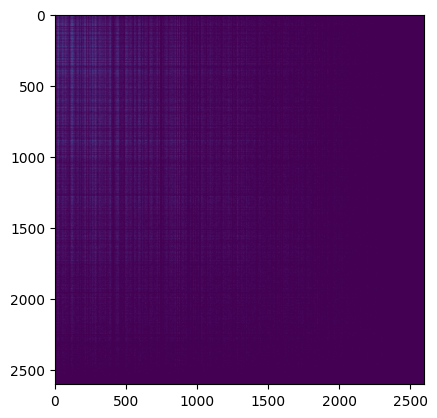

In [84]:
# since the interaction matrix ij only tracks the number of interactions from i to j and not j to i we sum the matrix with its transpose
# sim.interaction_matrix = sim.interaction_matrix + sim.interaction_matrix.transpose()

# plot interaction matrix
print("Total users:", len(sim.users))
print("Total groups:", len(sim.groups))
print("Median interactions", np.median(sim.interaction_matrix.toarray()))
print("Mean interactions", np.mean(sim.interaction_matrix.toarray()))
# finding mean interactions of users who have made at least one interaction
user_interaction_counts = np.sum(sim.interaction_matrix.toarray(), axis=1)
user_interaction_counts = user_interaction_counts[user_interaction_counts > 0]
print("Mean interactions with a given user > 0", np.mean(user_interaction_counts))
print("Max interactions", np.max(sim.interaction_matrix.toarray()))
most_active_user = np.argmax(np.sum(sim.interaction_matrix.toarray(), axis=1))
print("Most active user", most_active_user)
most_active_pair = np.unravel_index(np.argmax(sim.interaction_matrix.toarray()), sim.interaction_matrix.toarray().shape)
print("Most active pair", most_active_pair, sim.interaction_matrix[most_active_pair[0], most_active_pair[1]])
# mean interactions of pairs of users with at least 1 interaction of each other
pair_interaction_counts = []
for i in range(len(sim.users)):
    for j in range(len(sim.users)):
        if sim.interaction_matrix[i, j] > 0 and sim.interaction_matrix[j, i] > 0:
            pair_interaction_counts.append(sim.interaction_matrix[i, j] + sim.interaction_matrix[j, i])
pair_interaction_counts = np.array(pair_interaction_counts)
print("Mean comments (of pairs with at least 1 interaction)", np.mean(pair_interaction_counts))
print("Max interactions", np.max(sim.interaction_matrix.toarray()))
plt.imshow(np.log(sim.interaction_matrix.toarray() + 1))
plt.show()

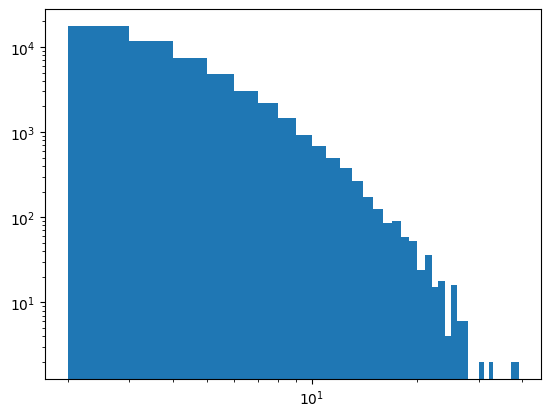

In [85]:
plt.hist(pair_interaction_counts, bins=(np.max(pair_interaction_counts) - np.min(pair_interaction_counts)))
plt.xscale("log")
plt.yscale("log")
plt.show()

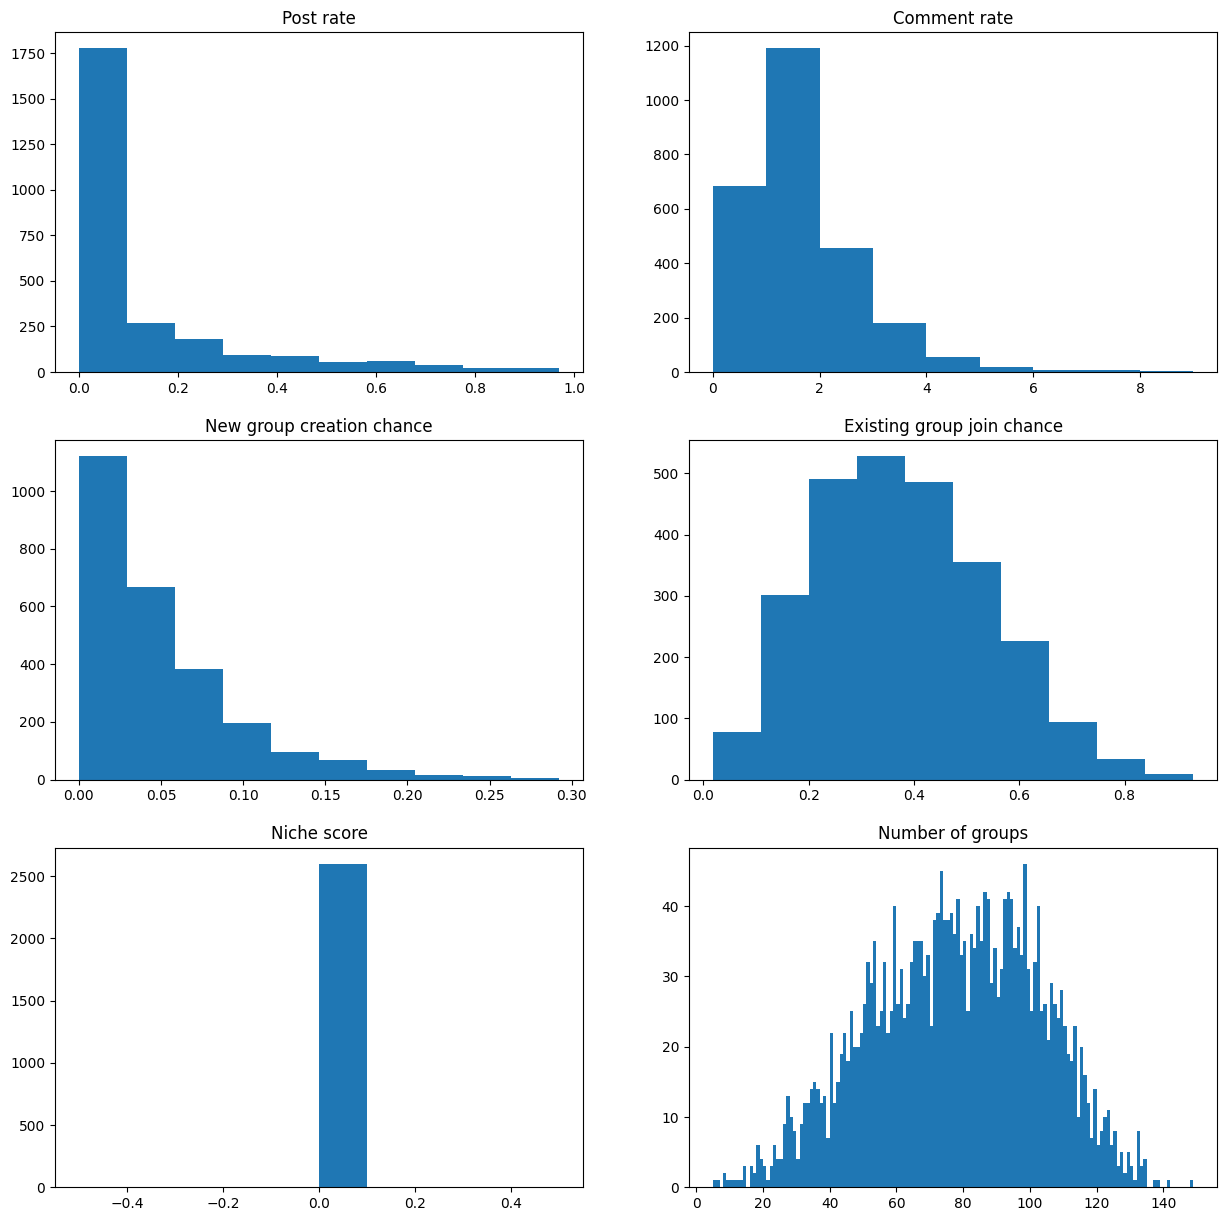

In [86]:
all_user_post_rate = []
all_user_comment_rate = []
all_user_new_group_creation_chance = []
all_user_existing_group_join_chance = []
all_user_niche_score = []
all_user_group_counts = []

for sim in sims:
    all_user_post_rate.extend([user.post_rate for user in sim.users])
    all_user_comment_rate.extend([user.comment_rate for user in sim.users])
    all_user_new_group_creation_chance.extend([user.new_group_creation_chance for user in sim.users])
    all_user_existing_group_join_chance.extend([user.existing_group_join_chance for user in sim.users])
    all_user_niche_score.extend([user.niche_score for user in sim.users])
    all_user_group_counts.extend([len(user.groups) for user in sim.users])

percentage_bin_size = min(
    [
        len(np.unique(all_user_post_rate)),
        len(np.unique(all_user_comment_rate)),
        len(np.unique(all_user_new_group_creation_chance)),
        len(np.unique(all_user_existing_group_join_chance)),
        len(np.unique(all_user_niche_score)),
        len(np.unique(all_user_group_counts)),
    ]
)

percentage_bin_size = 10

# subplot for each user attribute
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs[0, 0].hist(all_user_post_rate, bins=percentage_bin_size)
axs[0, 0].set_title("Post rate")
axs[0, 1].hist(all_user_comment_rate, bins=np.unique(all_user_comment_rate))
axs[0, 1].set_title("Comment rate")
axs[1, 0].hist(all_user_new_group_creation_chance, bins=percentage_bin_size)
axs[1, 0].set_title("New group creation chance")
axs[1, 1].hist(all_user_existing_group_join_chance, bins=percentage_bin_size)
axs[1, 1].set_title("Existing group join chance")
axs[2, 0].hist(all_user_niche_score, bins=percentage_bin_size)
axs[2, 0].set_title("Niche score")
axs[2, 1].hist(all_user_group_counts, bins=(round(np.max(all_user_group_counts) - np.min(all_user_group_counts))))
axs[2, 1].set_title("Number of groups")
plt.show()

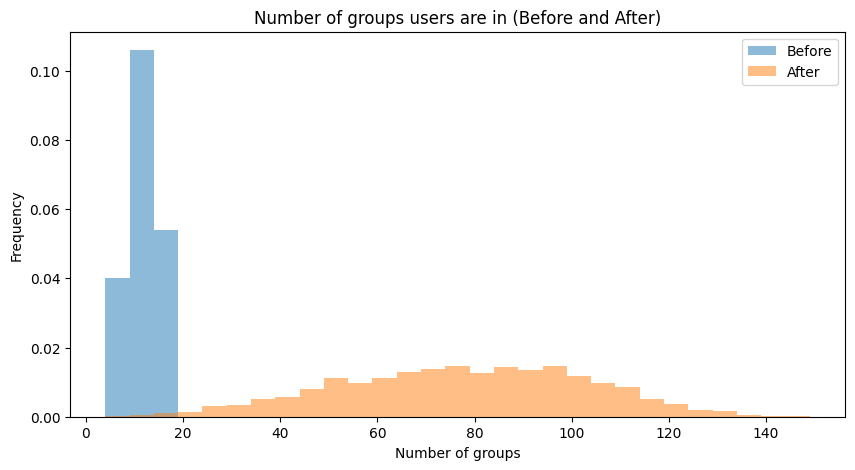

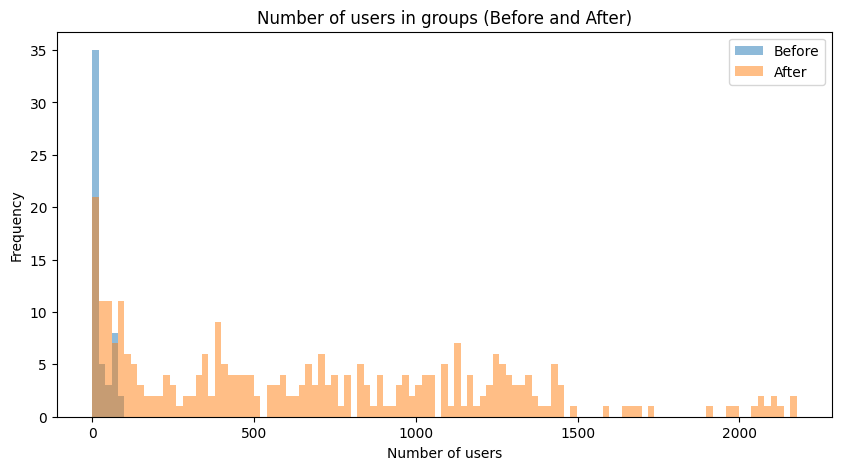

In [87]:
# Create a histogram to compare "before" and "after" user group counts
user_groups_min = min([min(counts) for counts in before_sim_user_group_counts])
user_groups_max = max([max(counts) for counts in after_sim_user_group_counts])
plt.figure(figsize=(10, 5))
plt.hist(
    [count for counts in before_sim_user_group_counts for count in counts],
    alpha=0.5,
    range=(user_groups_min, user_groups_max),
    bins=round((user_groups_max - user_groups_min) / 5),
    density=True,
    label="Before",
)
plt.hist(
    [count for counts in after_sim_user_group_counts for count in counts],
    alpha=0.5,
    range=(user_groups_min, user_groups_max),
    bins=round((user_groups_max - user_groups_min) / 5),
    density=True,
    label="After",
)
plt.title("Number of groups users are in (Before and After)")
plt.xlabel("Number of groups")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Create a histogram to compare "before" and "after" group user counts
group_user_counts_min = min([min(counts) for counts in before_sim_group_user_counts])
group_user_counts_max = max([max(counts) for counts in after_sim_group_user_counts])
plt.figure(figsize=(10, 5))
plt.hist(
    [count for counts in before_sim_group_user_counts for count in counts],
    alpha=0.5,
    range=(group_user_counts_min, group_user_counts_max),
    bins=round((group_user_counts_max - group_user_counts_min) / 20),
    # density=True,
    label="Before",
)
plt.hist(
    [count for counts in after_sim_group_user_counts for count in counts],
    alpha=0.5,
    range=(group_user_counts_min, group_user_counts_max),
    bins=round((group_user_counts_max - group_user_counts_min) / 20),
    # density=True,
    label="After",
)
plt.title("Number of users in groups (Before and After)")
plt.xlabel("Number of users")
plt.ylabel("Frequency")
# plt.xscale("log")
# plt.yscale("log")
plt.legend()
plt.show()